In [1]:
import json
import SimpleITK as sitk
from glob import glob 
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import glob
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import morphology
from skimage import measure, feature
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import imutils
from PIL import Image
import pickle
from multiprocessing import Pool
Algo_flag = True

In [2]:
def get_full_scan(folder_path):

    files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
    itkimage = sitk.ReadImage(files_List[0])
    rows = int(itkimage.GetMetaData('0028|0010'))
    cols = int(itkimage.GetMetaData('0028|0011'))
    mn = 1000
    mx = 0
    for file in tqdm(files_List):
        itkimage = sitk.ReadImage(file)
        mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
        mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')

    for file in tqdm(files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n-mn,:,:] = img[0,:,:]

    return full_scan

def dcm_image(filename):
    global Algo_flag
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    ins = float(itkimage.GetMetaData('0020|0013'))
    #print(ins)
    #if ins==1.0:
    #    print("we here")
    #    print(itkimage.GetMetaData('0020|1041'))
    #    if int(itkimage.GetMetaData('0020|1041'))==153:
    #        Algo_flag = False
        
#     numpyImage = get_normalized(numpyImage,wc,wl)
    return numpyImage, ins

def get_normalized(scan,mn,mx):
    np.clip(scan, mn, mx, out=scan)
    d = mx - mn
    scan = (scan-mn)/d
    return scan

def make_full_contour(img,mask):
        
    kernel_0 = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
    output = cv2.filter2D(mask, -1, kernel_0)
    con_ones = np.where(output > 0, 1, 0)
    con_zeros = 1 - con_ones
    
    RGB_img = np.zeros([img.shape[0],img.shape[1],3],int)
    RGB_img[:,:,2] = img*con_zeros*255 + con_ones*255
    RGB_img[:,:,0] = img*con_zeros*255
    RGB_img[:,:,1] = img*con_zeros*255
    
    return RGB_img

def plot_3d(image, threshold=100, alpha=0.5):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=alpha)
    face_color = [0.8, 0.2, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
def get_Filename(file):
    file = file.split('/')[-1]
    file = file.split('.')[0]
    return file

def normalize_3D_scan(scan, msk):
    nscan = np.zeros((512, 512, scan.shape[2]), 'uint8')
    nmsk = np.zeros((512, 512, scan.shape[2]), 'uint8')
    for i in tqdm(range(scan.shape[2])):
        s = scan[:,:,i]
        m = msk[:,:,i]
        s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_CUBIC)
        m = cv2.resize(m, (512, 512), interpolation=cv2.INTER_NEAREST)
        nscan[:,:,i] = s
        nmsk[:,:,i] = m
    nnscan = np.zeros((512, 512, 512), 'uint8')
    nnmsk = np.zeros((512, 512, 512), 'uint8')
    
    for i in range(512):
        s = nscan[i,:,:]
        m = nmsk[i,:,:]
        s = cv2.resize(s, (512, 512), interpolation=cv2.INTER_CUBIC)
        m = cv2.resize(m, (512, 512), interpolation=cv2.INTER_NEAREST)
        nnscan[i,:,:] = s
        nnmsk[i,:,:] = m
        
    return nnscan, nnmsk

def readJsonLeft(file,sz):
    
    mask = np.zeros(sz)
    mask = mask.astype('uint8')

    with open(file) as json_file:
        data = json.load(json_file)   

    left_coords = data['annotation']['tooth']['Left']['coordinate']

    l = int(len(left_coords)/3)
    b = {}
    b[0] = np.zeros((l, 1))
    b[1] = np.zeros((l, 1))
    b[2] = np.zeros((l, 1))
    j = 0
    for x in range(0, len(left_coords), 3):
        b[0][j] = int(left_coords[x])
        b[1][j] = int(left_coords[x+1])
        b[2][j] = int(left_coords[x+2])
        j = j + 1

    for i in range(len(b[0])):
        mask[int(b[2][i]), int(b[1][i]), int(b[0][i])] = 1

    return mask
    
def readJsonRight(file,sz):
    
    mask = np.zeros(sz)
    mask = mask.astype('uint8')

    with open(file) as json_file:
        data = json.load(json_file)   

    left_coords = data['annotation']['tooth']['Right']['coordinate']

    l = int(len(left_coords)/3)
    b = {}
    b[0] = np.zeros((l, 1))
    b[1] = np.zeros((l, 1))
    b[2] = np.zeros((l, 1))
    j = 0
    for x in range(0, len(left_coords), 3):
        b[0][j] = int(left_coords[x])
        b[1][j] = int(left_coords[x+1])
        b[2][j] = int(left_coords[x+2])
        j = j + 1

    for i in range(len(b[0])):
        mask[int(b[2][i]), int(b[1][i]), int(b[0][i])] = 1

    return mask

def plot_3dd(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces, norm, val = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
def crop(scan1,left, right):
    scan = get_normalized(scan1,-250,500)
    msk = left + right
    msk = np.where(msk>1, 1, msk)
    org_l = np.sum(left)
    org_r = np.sum(right)
    print("original left: " + str(org_l))
    print("original right: " + str(org_r))
    coords = np.zeros((scan.shape[0],1))
    cutoff_1 = int((scan.shape[0])*1/4)
    cutoff_2 = int(scan.shape[0] - ((scan.shape[0])*2/5))
    flag = 0
    for k in range(scan.shape[0]):
        for i in range(scan.shape[1]):
            for j in range(scan.shape[2]):
                if scan[k,i,j] >0:
                    coords[k] = i
                    flag = 1
                    break
            if flag==1:
                flag = 0
                break
    coords = coords[cutoff_1:cutoff_2]
    #plt.plot(coords)
    depth_cutoff = np.argmin(coords)
    #print(mini)
    depth_cutoff = cutoff_1 + depth_cutoff #depth crop
    #print(mini)
    ear_coords = np.zeros(((scan.shape[0]-depth_cutoff),2))
    flag = 0
    for k in range(depth_cutoff,scan.shape[0],1):
        for j in range(scan.shape[2]):
            for i in range(scan.shape[1]-1,-1,-1):
                if scan[k,i,j] > 0:
                    ear_coords[k-depth_cutoff]=[j,i]
                    flag = 1
                    break
            if flag==1:
                flag = 0
                break
    ear_cutoff = int(ear_coords[np.argmin(ear_coords[:-10,0]),1])
    chin_coords = np.zeros(((scan.shape[0]-depth_cutoff),1))
    flag = 0
    for k in range(depth_cutoff,scan.shape[0],1):
        for i in range(scan.shape[1]):
            for j in range(scan.shape[2]):
                if scan[k,i,j] >0:
                    #print("slice: " + str(k))
                    #print("row: " + str(i))
                    #print("column: " + str(j))
                    chin_coords[k-depth_cutoff]=i
                    flag = 1
                    break
            if flag==1:
                flag = 0
                break
    cutoff = int((chin_coords.shape[0])*(1/4))
    chin_coords = chin_coords[cutoff:-10]
    chin_cutoff = int(np.amin(chin_coords))
    img = scan[depth_cutoff,:,:]
    img = img>0
    #plt.imshow(img)
    img = skimage.morphology.remove_small_objects(img, min_size=600)
    img = img.astype(np.uint8)
    kernel = np.ones((30, 30), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = img.astype(np.uint8)
    img2 = morphology.binary_fill_holes(img)
    rowimg=img2.sum(axis=0)
    peak = np.argmax(rowimg) #column crop
    rowgr = np.gradient(rowimg)
    #cutoff = int(img.shape[1] * 1/2)
    rowgr_1 = np.argmax(rowgr[:(peak-150)])
    rowgr_2 = np.argmin(rowgr[peak+150:]) + peak+150
    #cutoff_11 = peak - 50
    #cutoff_22 = peak + 50
    scan = scan1[depth_cutoff+25:,:,:]
    msk = msk[depth_cutoff+25:,:,:]
    if rowgr_1>=25:
        rowgr_1 = rowgr_1 - 25
    scanright = scan[:,chin_cutoff:ear_cutoff+50,rowgr_1:peak]
    rightj = msk[:,chin_cutoff:ear_cutoff+50,rowgr_1:peak]
    leftj = msk[:,chin_cutoff:ear_cutoff+50,peak:rowgr_2-25]
    scanleft = scan[:,chin_cutoff:ear_cutoff+50,peak:rowgr_2-25]
    new_l = np.sum(leftj)
    new_r = np.sum(rightj)
    print("New left: " + str(new_l))
    print("New right: " + str(new_r))
    if org_l >= new_l:
        diff_l = org_l-new_l
    else:
        diff_l = new_l - org_l
    if org_r >= new_r:
        diff_r = org_r-new_r
    else:
        diff_r = new_r-org_r    
    return scanleft,scanright, leftj,rightj, diff_l,diff_r

In [3]:
files = glob.glob(r'/data/CBCT/all scans/json2/*.json')
source_folder = r'/data/CBCT/all scans/dcm2/'
des_dicoms = r'/data/CBCT/main_folders/'
des_masks = r'/data/CBCT/main_folders/'
error_array = np.empty((0,3), dtype = 'S')
for i in tqdm(range(17,40,1)):
    file = files[i]
    name = get_Filename(file)
    dFilename = source_folder + name
    try:
        print(name)
        scan = get_full_scan(dFilename)
        #scan = get_normalized(scan, -500, 1500)*255
        #scan = scan.astype('uint8') 
        right = readJsonRight(file,scan.shape) 
        left = readJsonLeft(file,scan.shape) 
        print("scanned")
        nscanl, nscanr, nleft , nright , l_diff, r_diff = crop(scan,left,right)
        error = [name,str(l_diff),str(r_diff)]
        print("cropped")
        print(error)
        error_array = np.vstack((error_array,error))
        filename = des_dicoms + get_Filename(file) + '_left.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nscanl, f)

        filename = des_dicoms + get_Filename(file) + '_right.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nscanr, f)
            
        filename = des_masks + get_Filename(file) + '_left.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nleft, f)
        filename = des_masks + get_Filename(file) + '_right.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nright, f)
        
    except: 
        pass

np.save(r'/data/CBCT/main_folders/error/first_20.npy',error_array)

  0%|          | 0/23 [00:00<?, ?it/s]

1780
scanned
original left: 8782
original right: 5274
New left: 8782
New right: 5274
cropped
['1780', '0', '0']


  4%|▍         | 1/23 [00:55<20:29, 55.87s/it]

2610
scanned
original left: 18921
original right: 19326
New left: 18921
New right: 19326
cropped
['2610', '0', '0']


  9%|▊         | 2/23 [02:32<23:52, 68.22s/it]

00125622_20200914
scanned
original left: 11737
original right: 12817
New left: 11737
New right: 12817
cropped
['00125622_20200914', '0', '0']


 13%|█▎        | 3/23 [02:50<17:39, 52.99s/it]

00132304_20200914
scanned
original left: 32022
original right: 35424
New left: 32022
New right: 35424
cropped
['00132304_20200914', '0', '0']


 17%|█▋        | 4/23 [03:12<13:51, 43.74s/it]

00102774_20201014
scanned
original left: 16538
original right: 17006
New left: 16538
New right: 17006
cropped
['00102774_20201014', '0', '0']


 22%|██▏       | 5/23 [03:33<11:04, 36.91s/it]

0411


 26%|██▌       | 6/23 [03:54<09:04, 32.05s/it]

0400
scanned
original left: 13207
original right: 15215
New left: 0
New right: 0
cropped
['0400', '13207', '15215']


 30%|███       | 7/23 [05:52<15:28, 58.00s/it]

2632
scanned
original left: 10700
original right: 10748
New left: 10700
New right: 10748
cropped
['2632', '0', '0']


 35%|███▍      | 8/23 [07:26<17:12, 68.84s/it]

1094


 39%|███▉      | 9/23 [07:38<12:01, 51.52s/it]

00132263_20200914
scanned
original left: 25932
original right: 25587
New left: 25932
New right: 25587
cropped
['00132263_20200914', '0', '0']


 43%|████▎     | 10/23 [07:59<09:13, 42.57s/it]

00032358_20201015
scanned
original left: 11108
original right: 10953
New left: 9526
New right: 8935
cropped
['00032358_20201015', '1582', '2018']


 48%|████▊     | 11/23 [08:21<07:14, 36.22s/it]

00080382_20201014
scanned
original left: 21956
original right: 21837
New left: 21956
New right: 21837
cropped
['00080382_20201014', '0', '0']


 52%|█████▏    | 12/23 [08:42<05:49, 31.80s/it]

00103535_20201014
scanned
original left: 5687
original right: 6099
New left: 5687
New right: 6099
cropped
['00103535_20201014', '0', '0']


 57%|█████▋    | 13/23 [09:05<04:52, 29.28s/it]

1157


 61%|██████    | 14/23 [09:23<03:51, 25.71s/it]

00125990_20200914
scanned
original left: 7488
original right: 7699
New left: 7488
New right: 7699
cropped
['00125990_20200914', '0', '0']


 65%|██████▌   | 15/23 [09:44<03:13, 24.19s/it]

00144017_20200916
scanned
original left: 20584
original right: 24550
New left: 20584
New right: 24550
cropped
['00144017_20200916', '0', '0']


 70%|██████▉   | 16/23 [10:05<02:43, 23.42s/it]

00145751_20200916
scanned
original left: 8115
original right: 8840
New left: 8115
New right: 8840
cropped
['00145751_20200916', '0', '0']


 74%|███████▍  | 17/23 [10:29<02:21, 23.56s/it]

00138423_20200911
scanned
original left: 27848
original right: 20005
New left: 27848
New right: 20005
cropped
['00138423_20200911', '0', '0']


 78%|███████▊  | 18/23 [10:52<01:56, 23.27s/it]

1139


 83%|████████▎ | 19/23 [11:02<01:18, 19.55s/it]

2662
scanned
original left: 17366
original right: 18090
New left: 17366
New right: 18090
cropped
['2662', '0', '0']


 87%|████████▋ | 20/23 [12:42<02:10, 43.65s/it]

0376
scanned
original left: 10070
original right: 12332
New left: 10070
New right: 11766
cropped
['0376', '0', '566']


 91%|█████████▏| 21/23 [13:59<01:47, 53.57s/it]

00128536_20200914
scanned
original left: 11317
original right: 7845
New left: 11317
New right: 7845
cropped
['00128536_20200914', '0', '0']


 96%|█████████▌| 22/23 [14:22<00:44, 44.36s/it]

1066


100%|██████████| 23/23 [14:33<00:00, 37.99s/it]


In [5]:
array = np.load(r'/data/CBCT/main_folders/error/first_20.npy')
print(array)

[]


9429
-1024.0
3071.0


<ipython-input-169-ab01c8ca57be>:59: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)


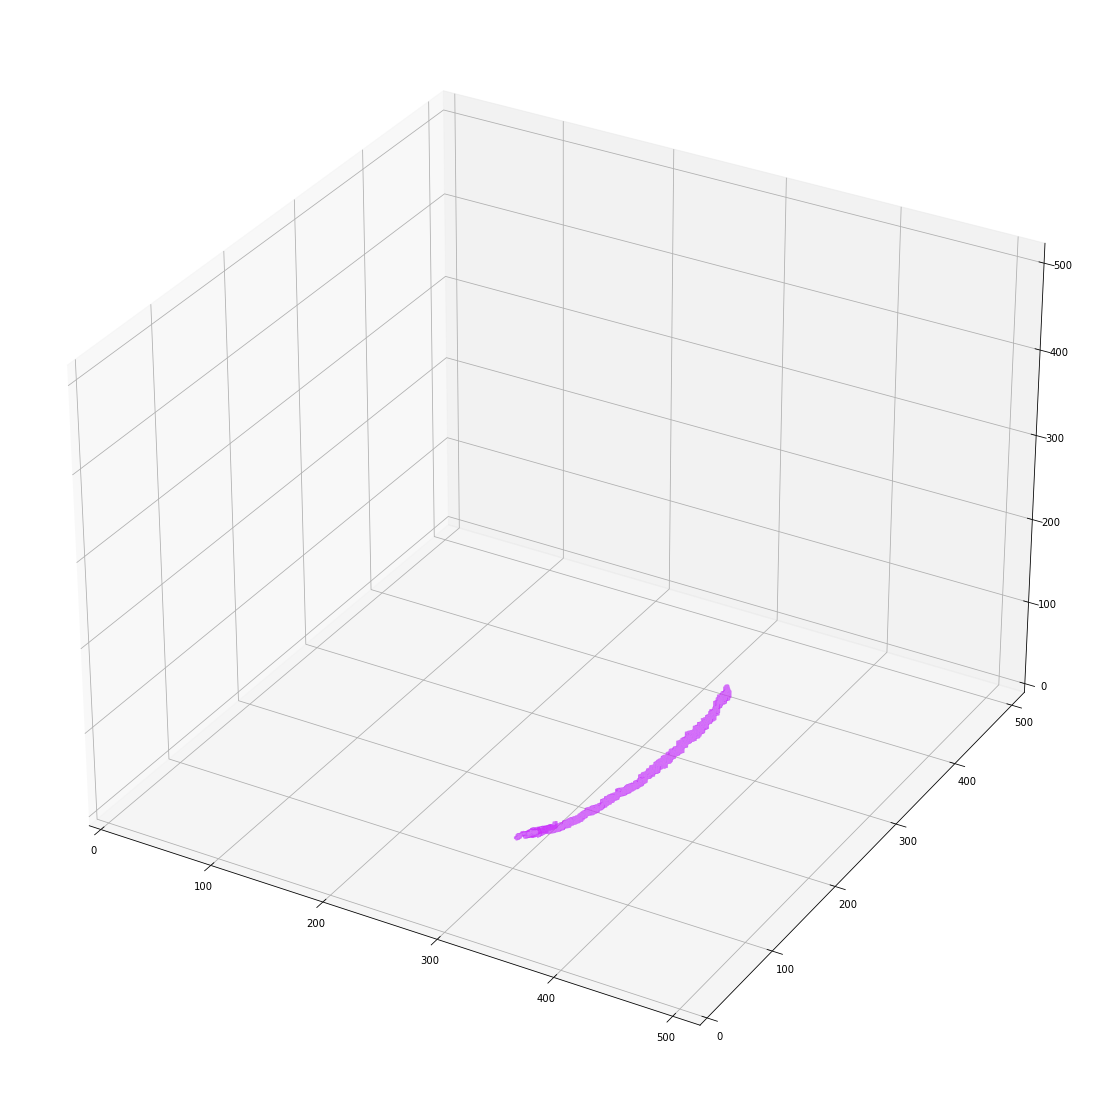

In [170]:
pathscan = r'/data/CBCT/all scans/dcm2/00145692_20200916'
pathjson = r'/data/CBCT/all scans/json2/00145692_20200916.json'
scan = get_full_scan(pathscan)

sz = scan.shape 
right= readJsonRight(pathjson,sz) 
left = readJsonLeft(pathjson,sz) 
msk = left + right
msk = np.where(msk>1, 1, msk)
print(np.sum(left))
print(np.min(scan))
print(np.max(scan))
plot_3d(left,0.5)
#nscan, nleft , nright = crop(scan,left,right)
            

<ipython-input-2-0975b0492997>:50: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)


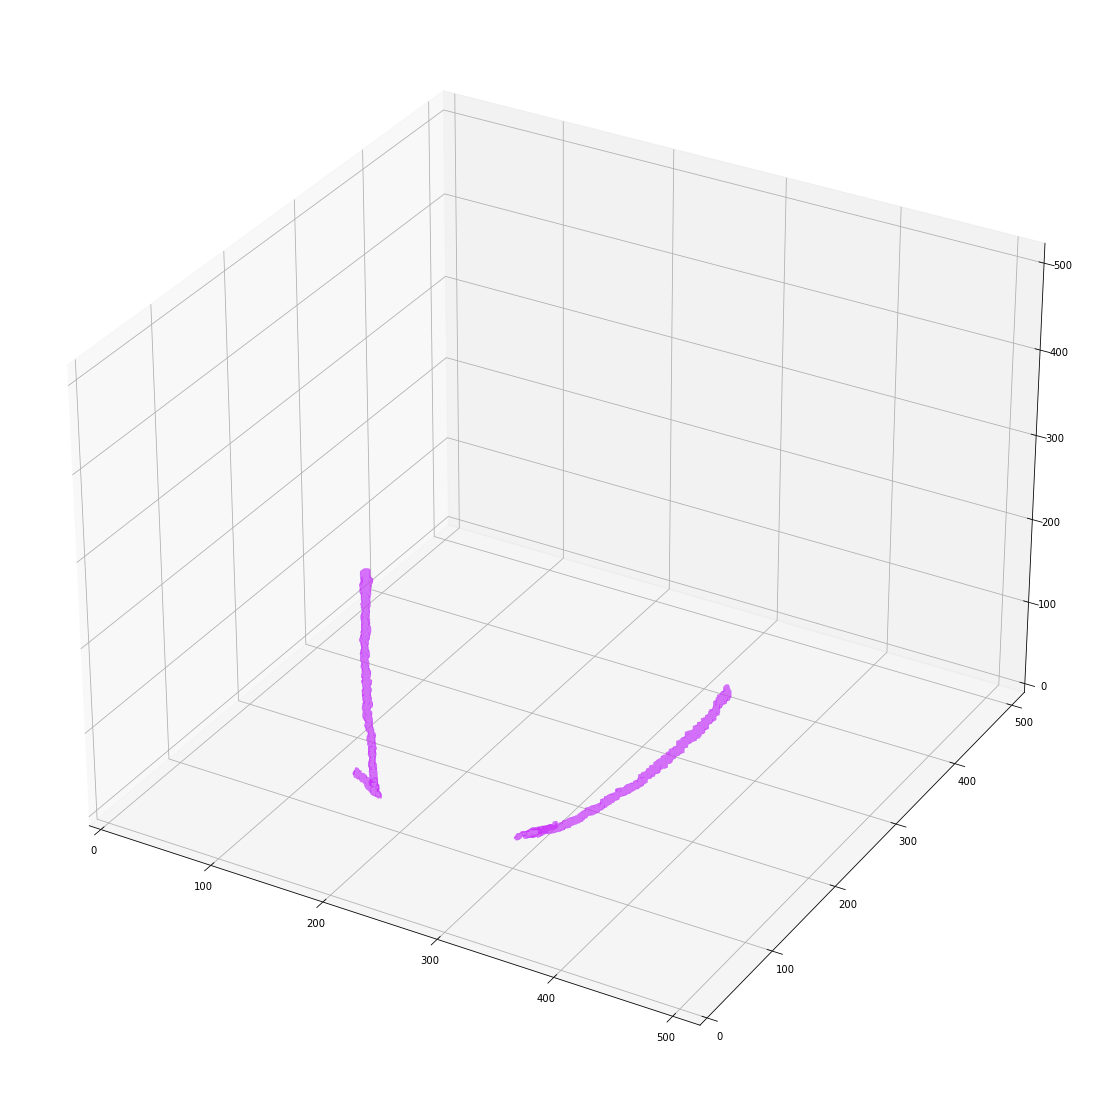

In [4]:
plot_3d(msk,0.5)

original left: 9429
original right: 10442
New left: 9429
New right: 10442
0
0


<ipython-input-169-ab01c8ca57be>:59: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)


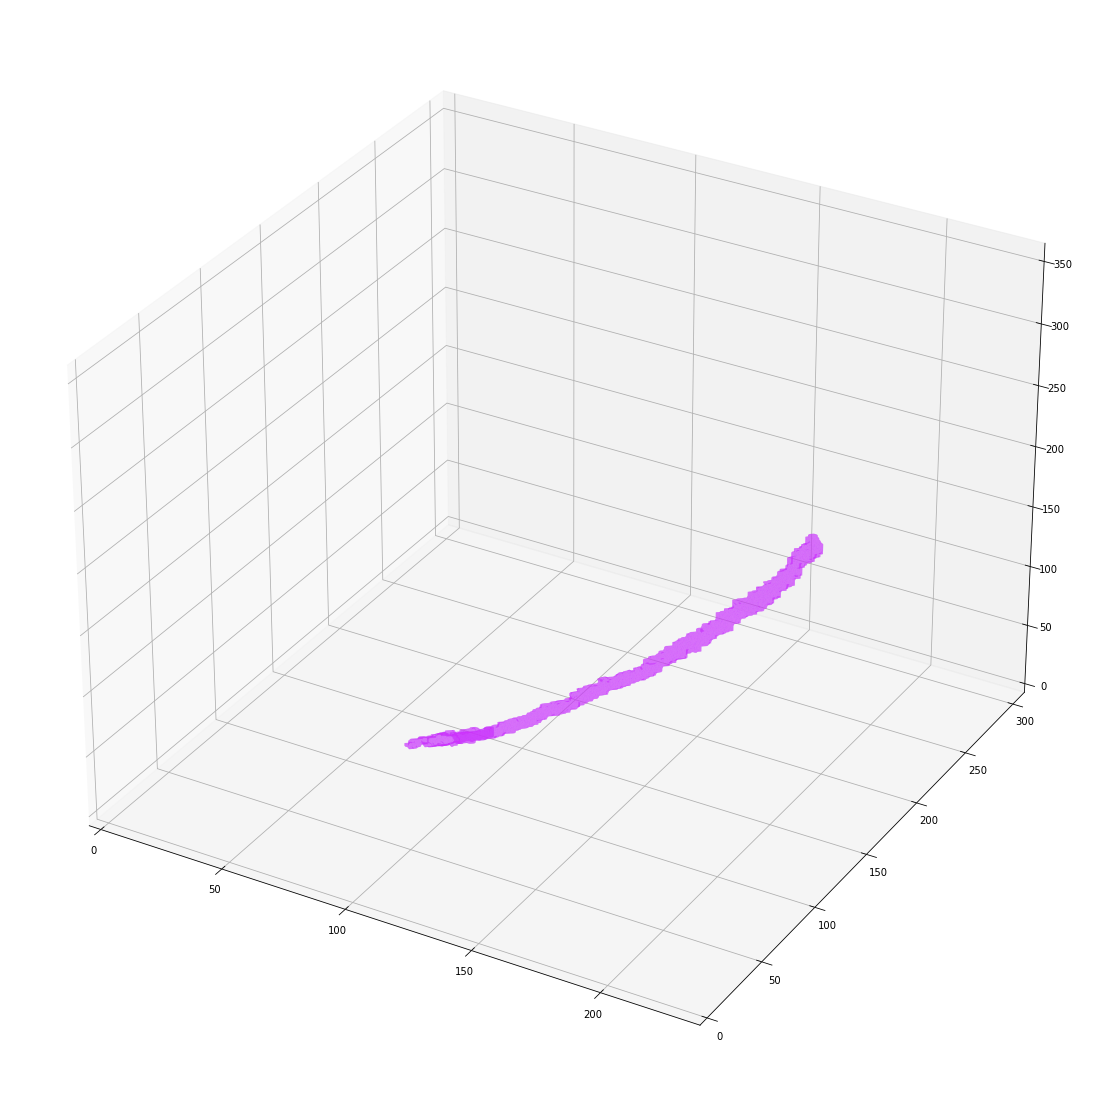

In [171]:
nscanl,nscanr, nleft , nright, d_l, d_r = crop(scan,left,right)
print(d_l)
print(d_r)
plot_3d(nleft,0.5)

In [167]:
plot_3d(nright,0.5)

<ipython-input-2-1d652c2f1eca>:59: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)


ValueError: Input array must be at least 2x2x2.

In [43]:
print(nleft.shape)

(332, 497, 287)


In [128]:
pathscan = r'/data/CBCT/all scans/dcm2/00078026_20201014'
scan = get_full_scan(pathscan)
pathjson = r'/data/CBCT/all scans/json2/00078026_20201014.json'
sz = scan.shape 
right= readJsonRight(pathjson,sz) 
left = readJsonLeft(pathjson,sz) 
msk = left + right
msk = np.where(msk>1, 1, msk)
org_l = np.sum(left)
org_r = np.sum(right)
print("original left: " + str(org_l))
print("original right: " + str(org_r))


original left: 10779
original right: 12542


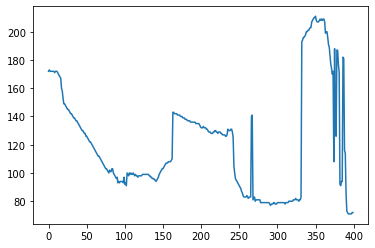

In [71]:
coords = np.zeros((scan.shape[0],1))
cutoff_1 = int((scan.shape[0])*1/4)
cutoff_2 = int(scan.shape[0] - ((scan.shape[0])*2/5))
flag = 0
for k in range(scan.shape[0]):
    for i in range(scan.shape[1]):
        for j in range(scan.shape[2]):
            if scan[k,i,j] > 0:
                coords[k] = i
                flag = 1
                break
        if flag==1:
            flag = 0
            break
plt.plot(coords)

2
102


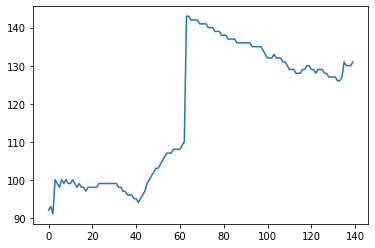

In [72]:
coords = coords[cutoff_1:cutoff_2]
plt.plot(coords)
mini = np.argmin(coords)
print(mini)
mini = cutoff_1 + mini

print(mini)

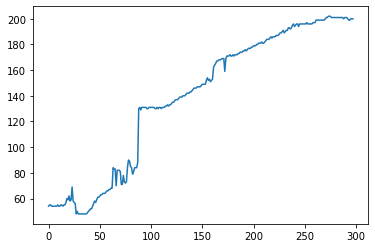

In [73]:
ear_coords = np.zeros(((scan.shape[0]-mini),2))

flag = 0
for k in range(mini,scan.shape[0],1):
    for j in range(scan.shape[2]):
        for i in range(scan.shape[1]-1,-1,-1):
            if scan[k,i,j] > 0:
                ear_coords[k-mini]=[j,i]
                if j==0 and i==0:
                    print(scan[k,i,j])
                flag = 1
                break
        if flag==1:
            flag = 0
            break
                
plt.plot(ear_coords[:,0])
#print(ear_coords)

In [74]:
cutoff = np.argmin(ear_coords[:-10,0])
print(cutoff)
print(ear_coords[cutoff])
ear_cutoff = int(ear_coords[cutoff,1])
print(ear_cutoff)

27
[ 48. 505.]
505


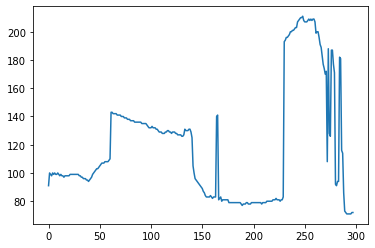

In [75]:
chin_coords = np.zeros(((scan.shape[0]-mini),1))
flag = 0
for k in range(mini,scan.shape[0],1):
    for i in range(scan.shape[1]):
        for j in range(scan.shape[2]):
            if scan[k,i,j] > 0:
                #print("slice: " + str(k))
                #print("row: " + str(i))
                #print("column: " + str(j))
                chin_coords[k-mini]=i
                flag = 1
                break
        if flag==1:
            flag = 0
            break
plt.plot(chin_coords)
#print(chin_coords)

77


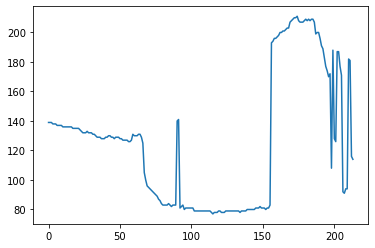

In [76]:
cutoff = int((chin_coords.shape[0])*(1/4))
chin_coords = chin_coords[cutoff:-10]
plt.plot(chin_coords)
chin_cutoff = int(np.amin(chin_coords))
print(chin_cutoff)

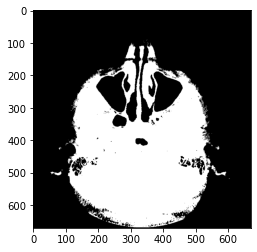

In [77]:
img = scan[mini,:,:]
img = img>0
plt.imshow(img, cmap = 'gray')
#rowimg = arr1.sum(axis=0)

In [78]:
img = skimage.morphology.remove_small_objects(img, min_size=600)
img = img.astype(np.uint8)
kernel = np.ones((30, 30), np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
img = img.astype(np.uint8)

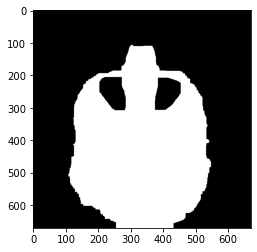

In [79]:
plt.imshow(img, cmap = 'gray')

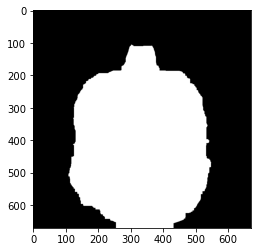

In [80]:
img2 = morphology.binary_fill_holes(img)
plt.imshow(img2, cmap = 'gray')

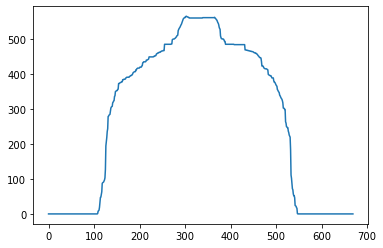

In [81]:
rowimg=img2.sum(axis=0)
plt.plot(rowimg)

In [82]:
peak = np.argmax(rowimg)
print(peak)

303


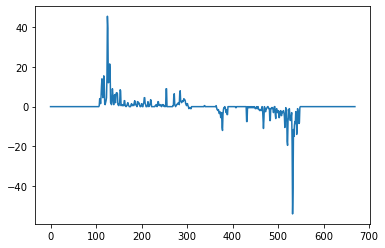

In [83]:
rowgr = np.gradient(rowimg)
plt.plot(rowgr)

In [84]:
col_cutoff = int(img.shape[1] * 1/3)
rowgr_1 = np.argmax(rowgr[:(peak-150)])
rowgr_2 = np.argmin(rowgr[peak+150:]) + peak+150
print(rowgr_1)
print(rowgr_2)

125
532


In [85]:
#cutoff_11 = peak - 50
#cutoff_22 = peak + 50
scani = scan[mini+25:,:,:]
mski = msk[mini+25:,:,:]
if rowgr_1>=25:
    rowgr_1 = rowgr_1 - 25
scanleft = scani[:,chin_cutoff:ear_cutoff+50,rowgr_1:peak]
rightj = mski[:,chin_cutoff:ear_cutoff+50,rowgr_1:peak]
leftj = mski[:,chin_cutoff:ear_cutoff+50,peak:rowgr_2+25]
scanright = scani[:,chin_cutoff:ear_cutoff+50,peak:rowgr_2+25]
new_l = np.sum(leftj)
new_r = np.sum(rightj)
org_l = np.sum(left)
org_r = np.sum(right)
diff_l = org_l-new_l
diff_r = org_r-new_r


In [86]:
print("original left: " + str(org_l))
print("original right: " + str(org_r))
print("New left: " + str(new_l))
print("New right: " + str(new_r))
print(diff_l)
print(diff_r)

original left: 9087
original right: 11387
New left: 9087
New right: 11387
0
0


In [87]:
print(scanleft.shape)
print(scanright.shape)

(273, 478, 203)
(273, 478, 254)


In [88]:
print(scan.shape)

(400, 670, 670)


<ipython-input-2-1d652c2f1eca>:59: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)


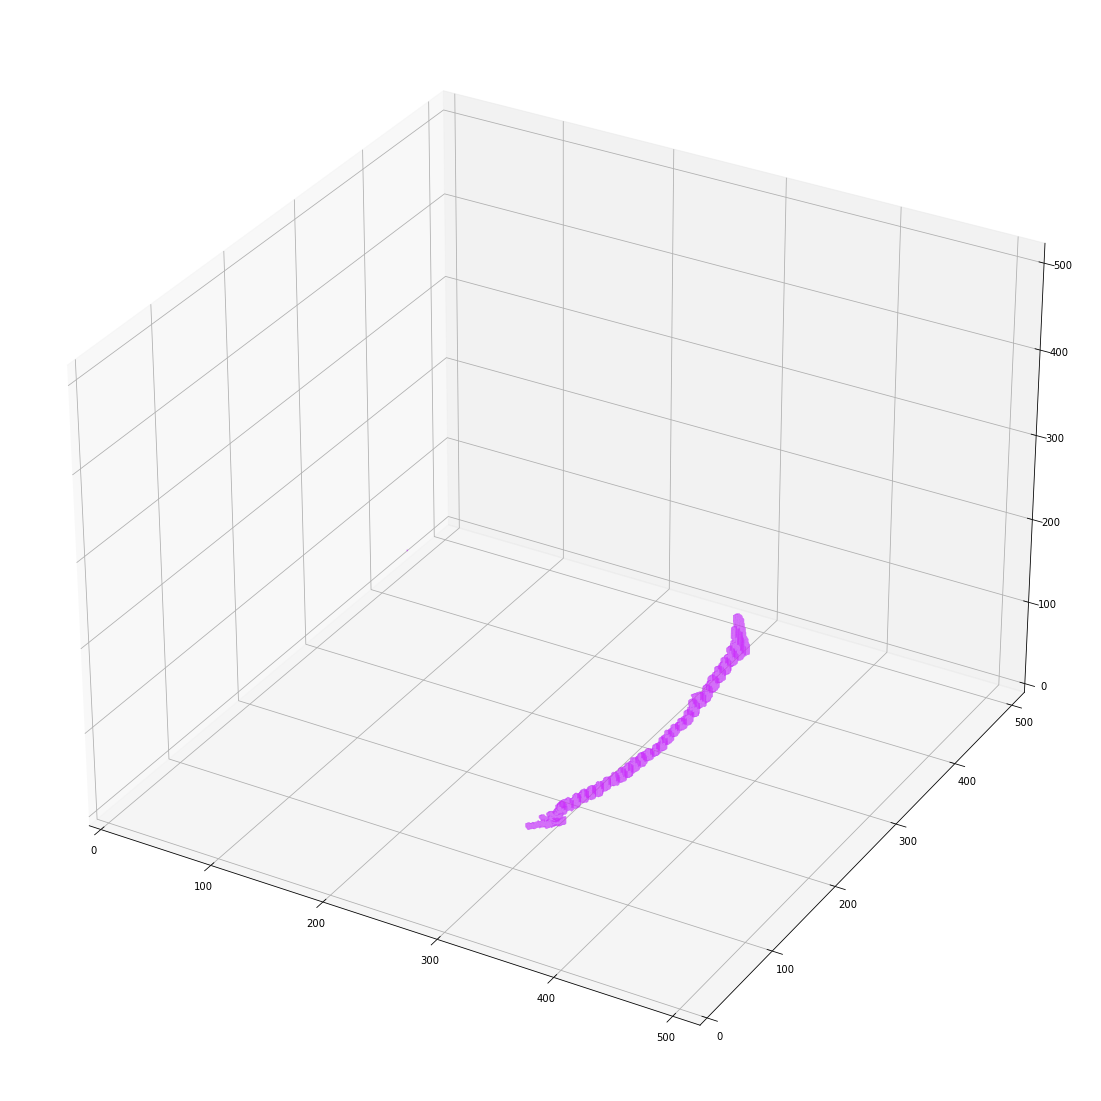

In [127]:
plot_3d(left,0.5)

<ipython-input-2-1d652c2f1eca>:59: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)


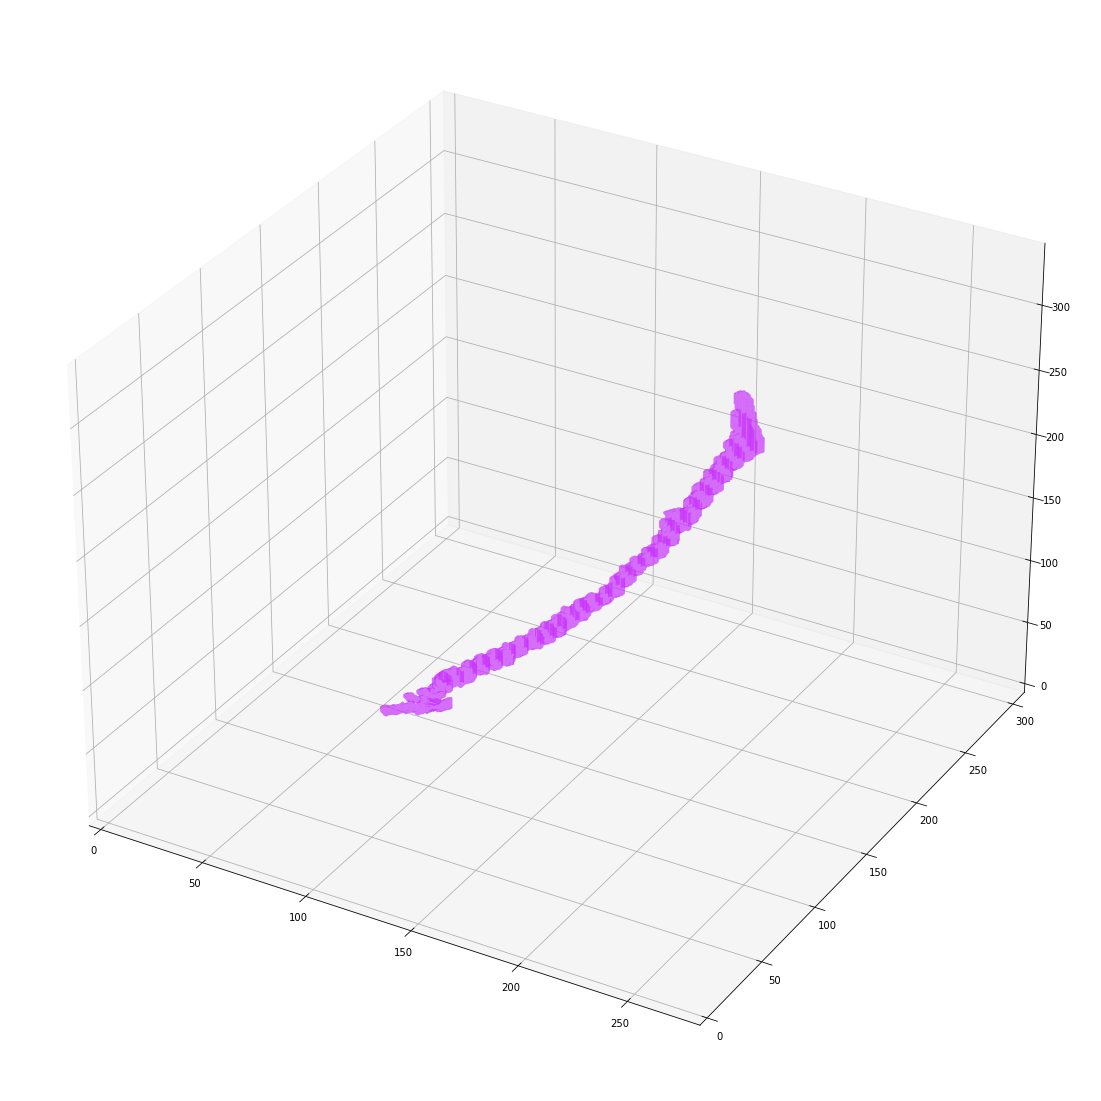

In [128]:
plot_3d(leftj,0.5)

<ipython-input-2-1d652c2f1eca>:59: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)


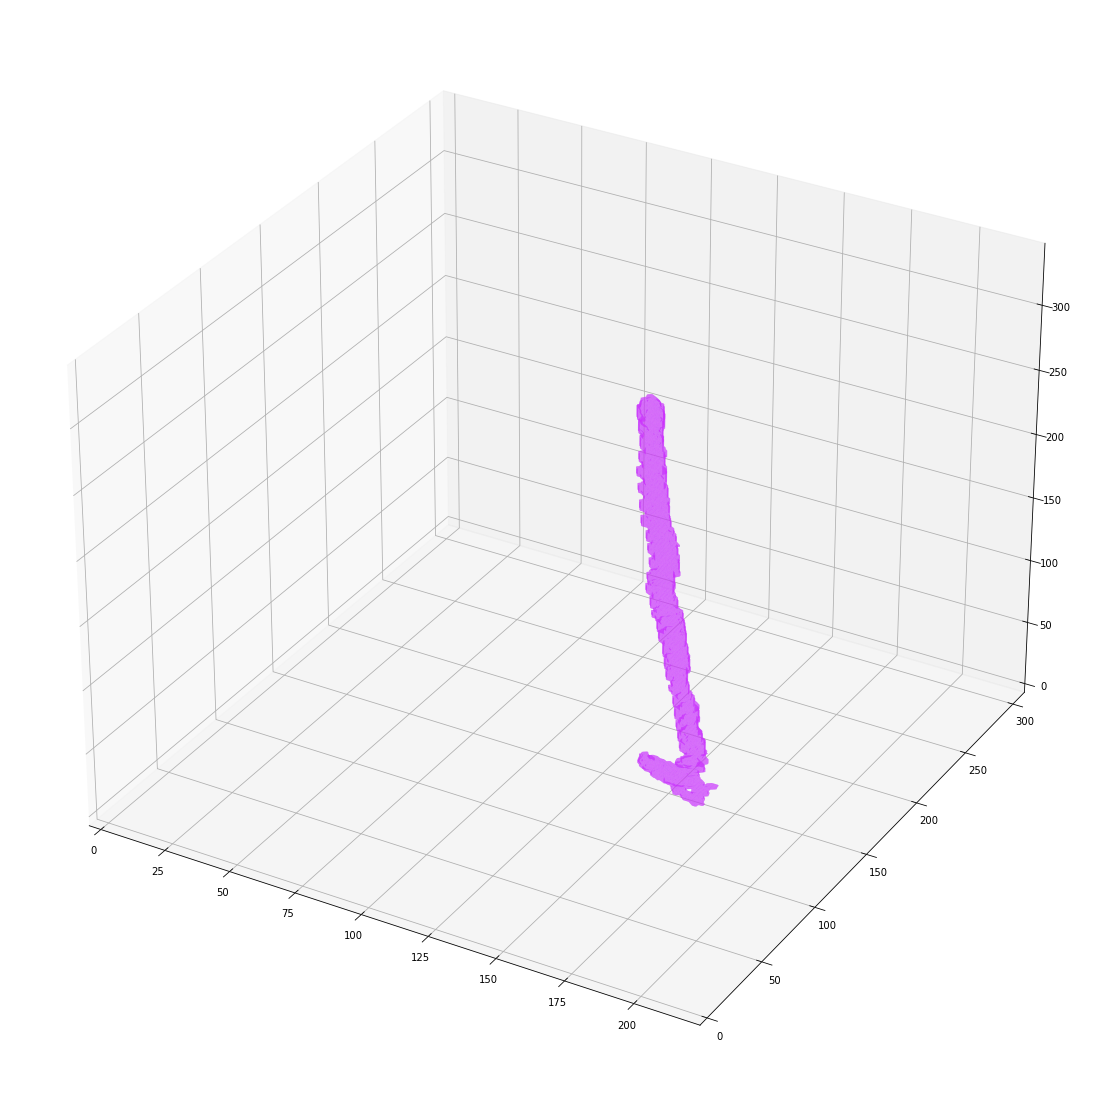

In [129]:
plot_3d(rightj,0.5)

<ipython-input-2-1d652c2f1eca>:59: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold)


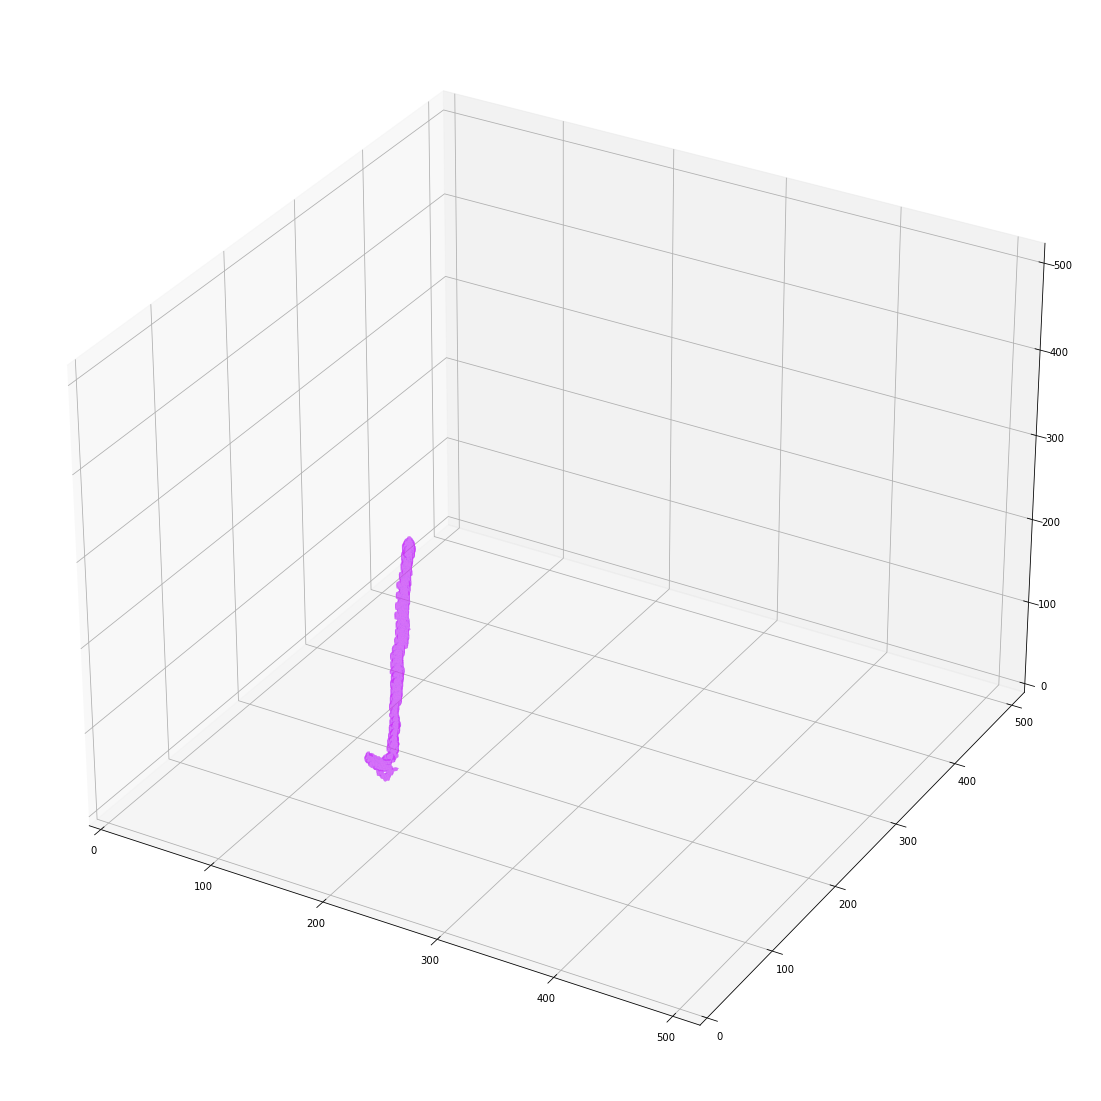

In [130]:
plot_3d(right,0.5)

138
298


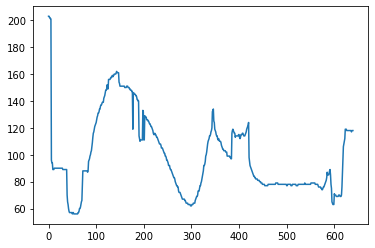

In [14]:
pathscan = r'/data/CBCT/all scans/dcm2/2649'
scan = get_full_scan(pathscan)
pathjson = r'/data/CBCT/all scans/json2/2649.json'
sz = scan.shape 
right= readJsonRight(pathjson,sz) 
left = readJsonLeft(pathjson,sz) 
msk = left + right
msk = np.where(msk>1, 1, msk)
coords = np.zeros((scan.shape[0],1))
cutoff_1 = int((scan.shape[0])*1/4)
cutoff_2 = int(scan.shape[0] - ((scan.shape[0])*1/3))
flag = 0
for k in range(scan.shape[0]):
    for i in range(scan.shape[1]):
        for j in range(scan.shape[2]):
            if scan[k,i,j] >= -450:
                coords[k] = i
                flag = 1
                break
        if flag==1:
            flag = 0
            break
plt.plot(coords)
coords = coords[cutoff_1:cutoff_2]
mini = np.argmin(coords)
print(mini)
mini = cutoff_1 + mini

print(mini)

In [18]:
ear_coords = np.zeros(((scan.shape[0]-mini),2))
print(ear_coords.shape)
flag = 0
for k in range(mini,scan.shape[0],1):
    for j in range(scan.shape[2]):
        for i in range(scan.shape[1]-1,-1,-1):
            if scan[k,i,j] >= -590:
                ear_coords[k-mini]=[j,i]
                flag = 1
                break
        if flag==1:
            flag = 0
            break
                
print(ear_coords)

(342, 2)
[[ 76. 508.]
 [ 76. 422.]
 [ 77. 436.]
 [ 77. 433.]
 [ 77. 433.]
 [ 77. 426.]
 [ 77. 425.]
 [ 77. 422.]
 [ 77. 415.]
 [ 77. 402.]
 [ 77. 406.]
 [ 77. 407.]
 [ 77. 407.]
 [ 78. 428.]
 [ 78. 421.]
 [ 78. 421.]
 [ 77. 485.]
 [ 76. 485.]
 [ 76. 489.]
 [ 76. 489.]
 [ 75. 488.]
 [ 75. 490.]
 [ 75. 492.]
 [ 74. 490.]
 [ 74. 490.]
 [ 73. 486.]
 [ 73. 488.]
 [ 73. 489.]
 [ 72. 482.]
 [ 72. 483.]
 [ 72. 486.]
 [ 72. 486.]
 [ 72. 486.]
 [ 72. 485.]
 [ 72. 485.]
 [ 72. 485.]
 [ 72. 485.]
 [ 72. 484.]
 [ 72. 484.]
 [ 72. 484.]
 [ 71. 483.]
 [ 71. 483.]
 [ 71. 483.]
 [ 72. 484.]
 [ 72. 482.]
 [ 72. 482.]
 [ 73. 483.]
 [ 73. 483.]
 [ 74. 482.]
 [ 75. 481.]
 [ 75. 480.]
 [ 76. 474.]
 [ 76. 473.]
 [ 77. 473.]
 [ 80. 461.]
 [ 79. 470.]
 [ 74. 427.]
 [ 74. 427.]
 [ 74. 427.]
 [ 74. 427.]
 [ 74. 430.]
 [ 73. 427.]
 [ 74. 430.]
 [ 73. 425.]
 [ 73. 425.]
 [ 66. 531.]
 [ 65. 530.]
 [ 65. 530.]
 [ 65. 530.]
 [ 65. 530.]
 [ 65. 530.]
 [ 65. 530.]
 [ 65. 530.]
 [ 65. 530.]
 [ 65. 530.]
 [ 65. 530.]
 [ 

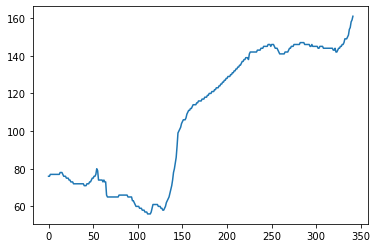

In [19]:
plt.plot(ear_coords[:,0])

In [20]:
ear_cutoff = ear_coords[np.argmin(ear_coords[:,0]),1]

In [21]:
print(ear_cutoff)

510.0


In [3]:
def get_cropped(i):
    global files ,source_folder, des_dicoms, des_masks, error_array
    file = files[i]
    name = get_Filename(file)
    dFilename = source_folder + name
    no = ['none', 'none', 'none']
    #try:
    print(name)
    try:
        scan = get_full_scan(dFilename)
    except:
        return no
    #scan = get_normalized(scan, -500, 1500)*255
    #scan = scan.astype('uint8') 
    right = readJsonRight(file,scan.shape) 
    left = readJsonLeft(file,scan.shape) 
    print("scanned")
    nscanl, nscanr, nleft , nright , l_diff, r_diff = crop(scan,left,right)
    error = [name,str(l_diff),str(r_diff)]
    print("cropped")
    print(error)
    
    #error_array = np.vstack((error_array,error))
    if l_diff==0 and r_diff==0:
        shp = [nscanl.shape[0],nscanl.shape[1],nscanl.shape[2],nscanr.shape[0],nscanr.shape[1],nscanr.shape[2]]
        filename = des_dicoms + name + '_left.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nscanl, f)

        filename = des_dicoms + name + '_right.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nscanr, f)

        filename = des_masks + name + '_left.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nleft, f)
        filename = des_masks + name + '_right.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nright, f)
    #print(error_array)
    #except: 
    #    pass
    return error

In [6]:
files = glob.glob(r'/data/CBCT/all scans/json2/*.json')
source_folder = r'/data/CBCT/all scans/dcm2/'
des_dicoms = r'/data/CBCT/main_folders/test/'
des_masks = r'/data/CBCT/main_folders/test/'
#error_array = np.empty((0,3), dtype = 'S')

p = Pool(3)
#error_array = p.map(get_cropped,range(len(files)))
error = p.map(get_cropped,range(3))
#np.save(r'/data/CBCT/main_folders/error/full.npy',error_array)
print('Done')

1397211900077651_20201014




  6%|▋         | 25/400 [00:00<00:18, 19.82it/s]

scanned


 17%|█▋        | 67/400 [00:01<00:07, 47.11it/s]

original left: 11879
original right: 12598


100%|██████████| 400/400 [00:07<00:00, 51.44it/s]


scanned
scanned
New left: 11879
New right: 12598
cropped
['00077651_20201014', '0', '0']
original left: 20321
original right: 18299
original left: 11699
original right: 11117
New left: 20321
New right: 18299
cropped
['2119', '0', '0']
New left: 11699
New right: 11117
cropped
['1397', '0', '0']
Done


In [113]:
shp = np.vstack(shapes)
shp = np.array(shp)
#print(depth)

[204 263 265   0 272 261 308 273 205   0 320 226 162 299   0 357 313 233
 294 301 306 316   0 316 324   0 334 193 354 184   0 185 327 325 341   0
 326   0 229   0 327   0 259 163   0 200 317   0 330 270 359 230 290   0
 300 302 275 348 247 282 192 311   0   0 319 297 269   0 213 297 214 273
 241 265   0 350   0 322 201 278 330 266   0 324 161 184   0 194 256 335
   0   0 257 296 255 192 214 345   0 337 204 263 265   0 272 261 308 273
 205   0 320 226 162 299   0 357 313 233 294 301 306 316   0 316 324   0
 334 193 354 184   0 185 327 325 341   0 326   0 229   0 327   0 259 163
   0 200 317   0 330 270 359 230 290   0 300 302 275 348 247 282 192 311
   0   0 319 297 269   0 213 297 214 273 241 265   0 350   0 322 201 278
 330 266   0 324 161 184   0 194 256 335   0   0 257 296 255 192 214 345
   0 337]


(array([46.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  6.,  0.,  0.,  0.,  0.,  4.,  2.,  2.,  0.,  0.,  0.,  2.,
         2.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  2.,  4.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  2.,  0.,  2.,  2.,  0.,  2.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.

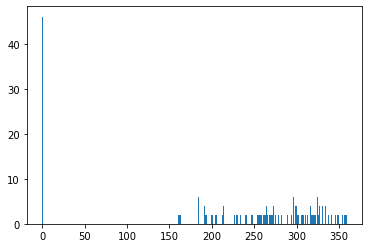

In [118]:
depth = shp[:,0]
depth = np.append(depth,shp[:,3])
width = shp[:,2]
width = np.append(width,shp[:,5])
height = shp[:,1]
height = np.append(height,shp[:,4])

print(depth)
plt.hist(depth, bins=256)

[345 438 446   0 441 448 490 478 320   0 463 351 301 483   0 306 305 453
 475 325 325 287   0 465 496   0 313 339 336 327   0 291 309 337 306   0
 509   0 351   0 308   0 296 264   0 279 331   0 325 483 306 483 348   0
 288 361 457 492 467 312 314 491   0   0 320 335 328   0 363 335 362 460
 469 460   0 317   0 323 360 468 306 468   0 327 350 360   0 272 486 511
   0   0 306 506 494 300 333 479   0 463 345 438 446   0 441 448 490 478
 320   0 463 351 301 483   0 306 305 453 475 325 325 287   0 465 496   0
 313 339 336 327   0 291 309 337 306   0 509   0 351   0 308   0 296 264
   0 279 331   0 325 483 306 483 348   0 288 361 457 492 467 312 314 491
   0   0 320 335 328   0 363 335 362 460 469 460   0 317   0 323 360 468
 306 468   0 327 350 360   0 272 486 511   0   0 306 506 494 300 333 479
   0 463]


(array([46.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,
         2.,  2.,  2.,  0.,  0.,  2.,  0.,  4.,  0.,  2., 10.,  4.,  0.,
         4.,  2.,  2.,  0.,  4.,  2.,  6.,  4.,  2.,  2.,  2.,  4.,  4.,
         2.,  0.,  0.,  2.,  0.,  2.,  6.,  0.,  0.

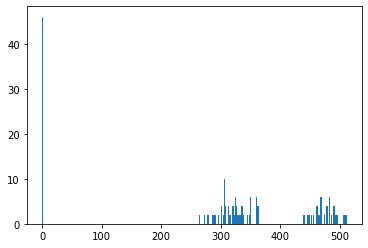

In [119]:
print(height)
plt.hist(height, bins=256)

[187 155 229   0 188 229 216 204 180   0 184 166 163 228   0 233 236 179
 186 233 231 238   0 172 196   0 233 176 231 163   0 158 237 221 232   0
 172   0 183   0 233   0 223 171   0 174 236   0 237 144 236 154 226   0
 250 232 201 226 131 225 180 197   0   0 223 240 234   0 170 232 170 176
 182 180   0 196   0 242 192 158 221 189   0 230 161 181   0 155 234 183
   0   0 251 184 147 149 179 196   0 196 212 216 219   0 233 199 253 203
 221   0 291 208 228 204   0 215 208 237 236 220 221 204   0 217 266   0
 220 253 224 182   0 200 211 239 219   0 264   0 204   0 220   0 214 221
   0 218 219   0 211 284 235 232 215   0 204 221 233 228 276 218 215 238
   0   0 228 215 220   0 227 218 236 256 209 249   0 225   0 212 203 274
 227 227   0 225 208 189   0 218 182 245   0   0 194 255 262 192 202 262
   0 278]


(array([46.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,  2.,  0.,  0.,  1.,  0.,
         2.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,  2.,  0.,  1.,  2.,  0.,
         0.,  2.,  3.,  1.,  5.,  2.,  0.,  1.,  1.,  1.,  2.,  0.,  2.,
         0.,  1.,  0.,  4.,  1.,  0.,  2.,  1.,  1.

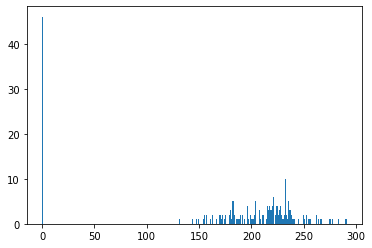

In [120]:
print(width)
plt.hist(width, bins=256)

In [65]:
error_file = np.load(r'/data/CBCT/main_folders/error/full.npy')
print(error_file)

[['00077651_20201014' '0' '0']
 ['1397' '0' '0']
 ['2119' '0' '0']
 ...
 ['none' 'none' 'none']
 ['2611' '0' '0']
 ['00137341_20200916' '0' '0']]


In [67]:
ok = 0
total = 0 
rel_ok = 0
rel_rel_ok = 0
for i in range(error_file.shape[0]):
    if not error_file[i,0]=='none':
        total = total +1
        if error_file[i,1]=='0' and error_file[i,2]=='0':
            ok = ok+1
        elif int(error_file[i,1]) <= 1000 and int(error_file[i,2]) <=1000:
            rel_ok = rel_ok +1
            if int(error_file[i,1]) <= 200 and int(error_file[i,2]) <=200:
                rel_rel_ok = rel_rel_ok+1
print(total)
print(ok)
per = 100*ok/total
print(per)
print(rel_ok)
print((100*(rel_ok+ok)/total))
print(rel_rel_ok)
print((100*(rel_rel_ok+ok)/total))

828
751
90.70048309178743
66
98.67149758454106
57
97.58454106280193


In [3]:
pathscan = r'/data/CBCT/all scans/dcm2/00133842_20200916'
pathjson = r'/data/CBCT/all scans/json2/00133842_20200916.json'
scan = get_full_scan(pathscan)
#print(Algo_flag)
#sz = scan.shape 

#right= readJsonRight(pathjson,sz) 
#left = readJsonLeft(pathjson,sz) 
#msk = left + right
#msk = np.where(msk>1, 1, msk)
#print(np.sum(left))
#print(np.min(scan))
#print(np.max(scan))
#plot_3d(msk,0.5)

(array([5.730e+04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 4.000e+00,
        7.000e+00, 2.000e+00, 7.000e+00, 1.300e+01, 9.000e+00, 1.300e+01,
        1.100e+01, 1.300e+01, 1.100e+01, 1.800e+01, 1.600e+01, 1.900e+01,
        1.100e+01, 1.300e+01, 2.500e+01, 1.500e+01, 2.000e+01, 2.100e+01,
        3.000e+01, 3.500e+01, 4.100e+01, 4.400e+01, 5.300e+01, 6.600e+01,
        9.700e+01, 1.220e+02, 1.580e+02, 2.040e+02, 2.360e+02, 3.210e+02,
        3.860e+02, 5.010e+02, 6.420e+02, 6.390e+02, 8.290e+02, 9.990e+02,
        1.078e+03, 1.294e+03, 1.501e+03, 1.572e+03, 1.837e+03, 1.887e+03,
        2.009e+03, 2.158e+03, 1.846e+03, 2.215e+03, 2.188e+03, 1.969e+03,
        1.787e+03, 1.685e+03, 1.583e+0

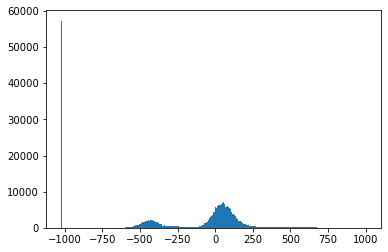

In [4]:
plt.hist(scan[0,:,:].flatten(), bins=256)

In [70]:
pathscan = r'/data/CBCT/all scans/dcm2/1968'
scan1 = get_full_scan(pathscan)
#plt.hist(scan1[0,:,:].flatten(), bins=256)
scan = get_normalized(scan1,-250,500)
pathjson = r'/data/CBCT/all scans/json2/1968.json'
#print(Algo_flag)
sz = scan.shape 

right= readJsonRight(pathjson,sz) 
left = readJsonLeft(pathjson,sz) 
msk = left + right
msk = np.where(msk>1, 1, msk)
print(np.sum(left))
print(np.min(scan))
print(np.max(scan))
#plot_3d(msk,0.5)

9087
0.0
1.0


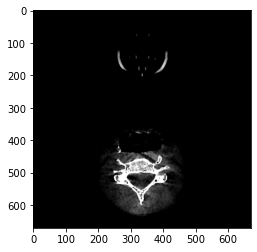

In [39]:
plt.imshow(scan[-1,:,:], cmap = 'gray')

(array([2.64275e+05, 3.85600e+03, 5.41700e+03, 6.53800e+03, 8.36200e+03,
        8.08500e+03, 4.45600e+03, 3.93700e+03, 3.62700e+03, 2.83500e+03,
        2.20600e+03, 1.85500e+03, 1.40100e+03, 1.15600e+03, 1.02700e+03,
        8.78000e+02, 8.48000e+02, 7.50000e+02, 6.67000e+02, 5.70000e+02,
        5.45000e+02, 4.61000e+02, 4.28000e+02, 4.06000e+02, 3.03000e+02,
        3.11000e+02, 2.80000e+02, 2.45000e+02, 2.53000e+02, 2.06000e+02,
        1.90000e+02, 2.27000e+02, 1.98000e+02, 1.71000e+02, 1.64000e+02,
        1.62000e+02, 1.45000e+02, 1.39000e+02, 1.48000e+02, 1.50000e+02,
        1.58000e+02, 1.44000e+02, 1.55000e+02, 1.59000e+02, 1.54000e+02,
        1.84000e+02, 1.87000e+02, 1.99000e+02, 1.85000e+02, 1.92000e+02,
        1.66000e+02, 2.06000e+02, 1.83000e+02, 1.85000e+02, 2.02000e+02,
        1.87000e+02, 2.03000e+02, 2.31000e+02, 2.45000e+02, 2.68000e+02,
        3.17000e+02, 3.43000e+02, 4.27000e+02, 5.11000e+02, 6.66000e+02,
        7.23000e+02, 8.67000e+02, 1.06000e+03, 1.21

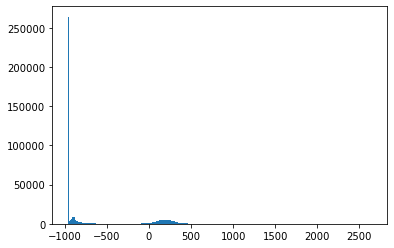

In [42]:
pathscan = r'/data/CBCT/all scans/dcm2/2694'
scan3 = get_full_scan(pathscan)
plt.hist(scan3[0,:,:].flatten(), bins=256)

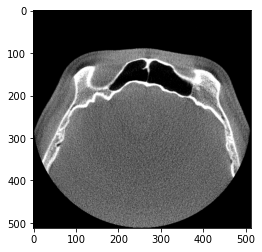

In [8]:
scan1_n = get_normalized(scan,-250,500)
plt.imshow(scan1_n[0,:,:], cmap = 'gray')

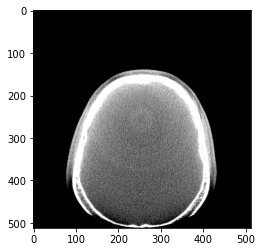

In [9]:
scan2_n = get_normalized(scan2,-250,500)
plt.imshow(scan2_n[0,:,:], cmap = 'gray')

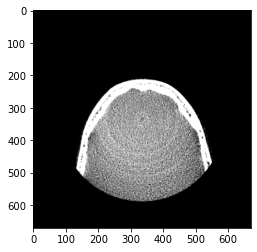

In [10]:
scan3_n = get_normalized(scan3,-250,500)
plt.imshow(scan3_n[0,:,:], cmap = 'gray')

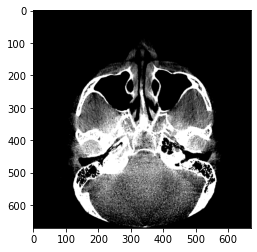

In [11]:
plt.imshow(scan3_n[298,:,:], cmap = 'gray')

In [4]:
files = glob.glob(r'/data/CBCT/all scans/json2/*.json')
print(len(files))

1010


In [5]:
no = ['none', 'none', 'none']
print(no)

['none', 'none', 'none']


In [6]:
a = 2-5
print(a)

-3


In [5]:
def get_cropped(i):
    global files ,source_folder, des_dicoms, des_masks, error_array
    file = files[i]
    name = get_Filename(file)
    dFilename = source_folder + name
    no = ['none', 'none', 'none']
    #try:
    print(name)
    try:
        scan = get_full_scan(dFilename)
    except:
        return no
    #scan = get_normalized(scan, -500, 1500)*255
    #scan = scan.astype('uint8') 
    right = readJsonRight(file,scan.shape) 
    left = readJsonLeft(file,scan.shape) 
    print("scanned")
    nscanl, nscanr, nleft , nright , l_diff, r_diff = crop(scan,left,right)
    error = [name,str(l_diff),str(r_diff)]
    print("cropped")
    print(error)
    #error_array = np.vstack((error_array,error))
    if l_diff==0 and r_diff==0:
        filename = des_dicoms + name + '_scan_left.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nscanl, f)

        filename = des_dicoms + name + '_scan_right.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nscanr, f)

        filename = des_masks + name + '_mask_left.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nleft, f)
        filename = des_masks + name + '_mask_right.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(nright, f)
    #print(error_array)
    #except: 
    #    pass
    return error
    